Session started: 2025-11-09 10:41:12.867160

[EDA]


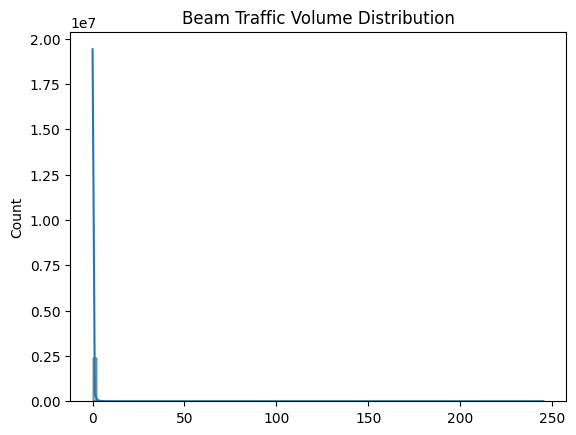

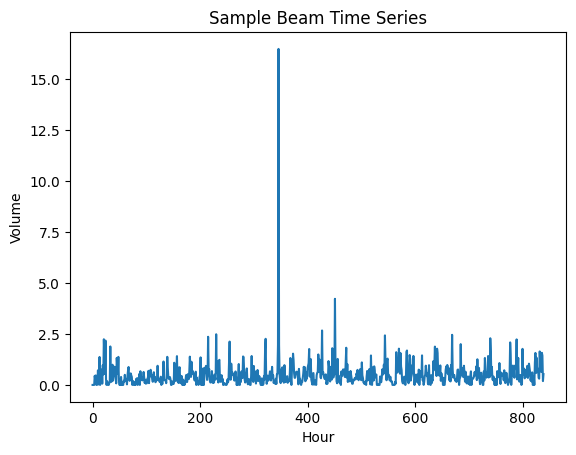

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step


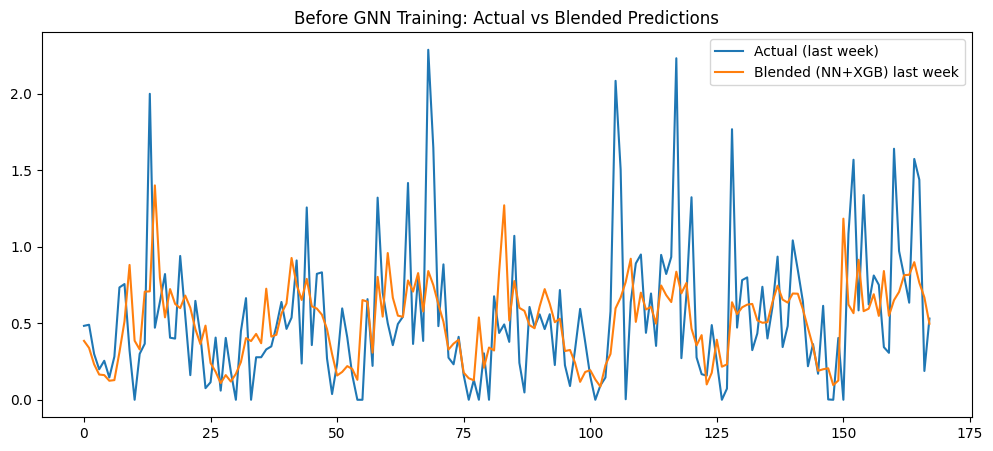

Done GNN training and prediction.

Best blend MAE: 0.16682 with weights [np.float64(0.1), np.float64(0.8500000000000001), np.float64(0.05)]


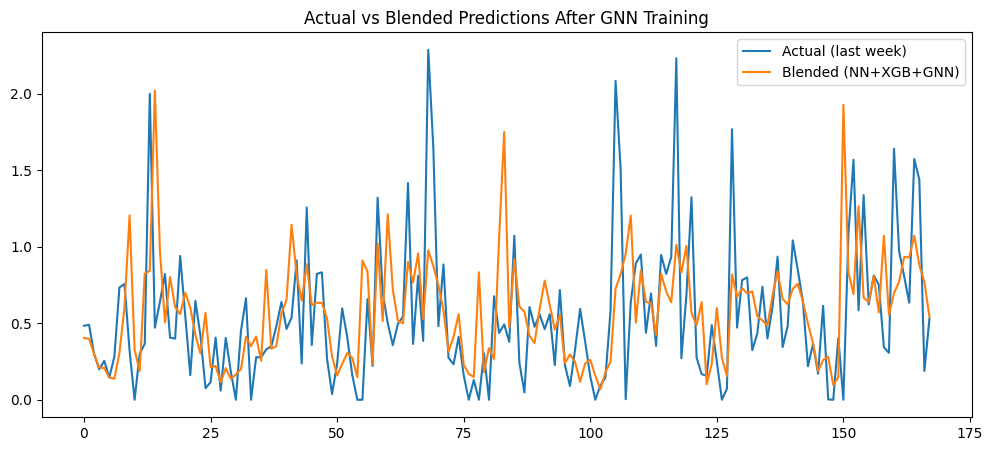


Running LIME explainability...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step



Session ended: 2025-11-09 10:48:54.009738


In [1]:
!pip install -q torch torchvision torchaudio torch-geometric lime xgboost matplotlib seaborn

import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import pickle

warnings.filterwarnings('ignore')

print("="*70)
print(f"Session started: {datetime.now()}")
print("="*70)

# File helper
def try_find(patterns):
    for pat in patterns:
        files = glob.glob(pat)
        if files: return files[0]
    return None

# Load files
traffic_csv = try_find(['traffic_DLThpVol.csv'])
prb_csv = try_find(['traffic_DLPRB.csv'])
ss_csv = try_find(['SampleSubmission.csv'])
meta_pkl = try_find(['model_metadata.pkl'])
nn_h5 = try_find(['pretrained_nn_model*.h5'])
xgb_json = try_find(['pretrained_xgb_model*.json'])
meta_model_pkl = try_find(['pretrained_meta_model*.pkl'])
scaler_pkl = try_find(['robust_scaler*.pkl'])

ty = pd.read_csv(traffic_csv)
prb = pd.read_csv(prb_csv)
ss = pd.read_csv(ss_csv)
with open(meta_pkl, 'rb') as f:
    metadata = pickle.load(f)

all_features = metadata['all_features']
n_beams = metadata.get('n_beams', 2880)
beam_columns = [f"{base}_{cell}_{beam}"
                for base in range(metadata.get('n_base',30))
                for cell in range(metadata.get('n_cell',3))
                for beam in range(metadata.get('n_beam',32))]
total_hours = metadata.get('total_hours', len(ty))

# EDA
print("\n[EDA]")
sns.histplot(ty[beam_columns].values.flatten(), bins=100, kde=True)
plt.title('Beam Traffic Volume Distribution')
plt.show()
plt.plot(ty[beam_columns[0]].values)
plt.title('Sample Beam Time Series')
plt.xlabel('Hour'); plt.ylabel('Volume'); plt.show()

# Feature engineering
def create_time_features(df, total_hours):
    hours = np.arange(total_hours) % 24
    days = (np.arange(total_hours) // 24) % 7
    df['hour_sin'] = np.sin(2*np.pi*hours/24)
    df['hour_cos'] = np.cos(2*np.pi*hours/24)
    df['day_sin'] = np.sin(2*np.pi*days/7)
    df['day_cos'] = np.cos(2*np.pi*days/7)
    df['is_weekend'] = ((days==5)|(days==6)).astype(int)
    df['is_peak_hour'] = np.isin(hours,[7,8,9,17,18,19]).astype(int)
    df['is_night'] = np.isin(hours,[0,1,2,3,4,5]).astype(int)
    return df

def create_lagged_features(df, beam_cols, lags=[1,6,12,24,168]):
    for lag in lags:
        df = pd.concat([df, df[beam_cols].shift(lag).add_suffix(f'_lag_{lag}')], axis=1)
    return df.fillna(0)

def add_rolling_averages(df, beam_cols, windows=[3,6,12,24]):
    for w in windows:
        roll = df[beam_cols].rolling(window=w, min_periods=1).mean()
        roll.columns = [f"{c}_rolling_{w}" for c in roll.columns]
        df = pd.concat([df, roll], axis=1)
    return df

def add_rolling_std(df, beam_cols, windows=[6,24]):
    for w in windows:
        roll_std = df[beam_cols].rolling(window=w, min_periods=1).std()
        roll_std.columns = [f"{c}_rolling_std_{w}" for c in roll_std.columns]
        df = pd.concat([df, roll_std], axis=1)
    return df.fillna(0)

def create_congestion_features(prb_df, ty_df, beam_cols):
    congestion_flag = (prb_df[beam_cols].mean(axis=1) > 0.8).astype(float)
    ty_df['congestion_interaction'] = congestion_flag*(ty_df['hour_sin']+ty_df['hour_cos'])
    ty_df['congestion_high'] = congestion_flag
    return ty_df

ty = create_time_features(ty, total_hours)
ty = create_lagged_features(ty, beam_columns)
ty = add_rolling_averages(ty, beam_columns)
ty = add_rolling_std(ty, beam_columns)
ty = create_congestion_features(prb, ty, beam_columns)

missing_feats = set(all_features) - set(ty.columns)
if missing_feats:
    print(f"Warning: Missing features: {list(missing_feats)[:5]}...")

X = ty[all_features]
y = ty[beam_columns]
split_idx = int(0.8*len(X))
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

from tensorflow.keras.models import load_model
import xgboost as xgb

nn_model = load_model(nn_h5, compile=False)
xgb_model = xgb.Booster()
xgb_model.load_model(xgb_json)
meta_model = joblib.load(meta_model_pkl)
scaler = joblib.load(scaler_pkl)

X_val_scaled = scaler.transform(X_val)
X_val_nn = np.expand_dims(X_val_scaled, axis=1)

y_pred_val_nn = nn_model.predict(X_val_nn)
dval = xgb.DMatrix(X_val_scaled)
y_pred_val_xgb = xgb_model.predict(dval).reshape(y_val.shape)
meta_val_input = np.concatenate([y_pred_val_nn, y_pred_val_xgb], axis=1)
y_pred_val_meta = meta_model.predict(meta_val_input)

blend_pred_before_gnn = 0.5*y_pred_val_nn + 0.5*y_pred_val_xgb

plt.figure(figsize=(12,5))
plt.plot(y_val.values[-168:,0], label='Actual (last week)')
plt.plot(blend_pred_before_gnn[-168:,0], label='Blended (NN+XGB) last week')
plt.title('Before GNN Training: Actual vs Blended Predictions')
plt.legend()
plt.show()

# GNN training & prediction
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.data import Data as GData
    from torch_geometric.nn import GCNConv

    tX = torch.tensor(X_val_scaled[:100], dtype=torch.float32)
    tY = torch.tensor(y_val.values[:100], dtype=torch.float32)
    edge_idx = torch.combinations(torch.arange(tX.size(0)), r=2).t()
    edge_idx = torch.cat([edge_idx, edge_idx.flip(0)], dim=1)

    class GNNModel(torch.nn.Module):
        def __init__(self, in_c, h, out_c):
            super().__init__()
            self.conv1 = GCNConv(in_c,h)
            self.conv2 = GCNConv(h,out_c)

        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = F.relu(self.conv1(x, edge_index))
            x = self.conv2(x, edge_index)
            return x

    gnn_model = GNNModel(tX.shape[1], 64, n_beams)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
    data = GData(x=tX, edge_index=edge_idx)

    gnn_model.train()
    for epoch in range(10):
        optimizer.zero_grad()
        out = gnn_model(data)
        loss = F.mse_loss(out, tY)
        loss.backward()
        optimizer.step()

    gnn_model.eval()
    with torch.no_grad():
        gnn_pred_val = gnn_model(data).cpu().numpy()
    print("Done GNN training and prediction.")
except Exception as e:
    print(f"GNN training/skipped error: {e}")
    gnn_pred_val = np.zeros_like(y_val[:100].values)

from sklearn.metrics import mean_absolute_error

if gnn_pred_val.shape[0]<y_val.shape[0]:
    pad_len = y_val.shape[0] - gnn_pred_val.shape[0]
    gnn_val = np.vstack([gnn_pred_val, np.zeros((pad_len, y_val.shape[1]))])
else:
    gnn_val = gnn_pred_val

best_mae = float('inf')
best_weights = [0,0,0]
blend_preds = None
weights_grid = np.arange(0,1.05,0.05)

for w0 in weights_grid:
  for w1 in weights_grid:
    for w2 in weights_grid:
      if abs(w0+w1+w2-1)>1e-6: continue
      blend = w0*y_pred_val_nn + w1*y_pred_val_xgb + w2*gnn_val
      mae = mean_absolute_error(y_val.values, blend)
      if mae < best_mae:
        best_mae = mae
        best_weights = [w0,w1,w2]
        blend_preds = blend
      if mae < 0.16:
        print(f"MAE < 0.16 with weights NN={w0:.2f}, XGB={w1:.2f}, GNN={w2:.2f}; MAE={mae:.5f}")

print(f"\nBest blend MAE: {best_mae:.5f} with weights {best_weights}")

plt.figure(figsize=(12,5))
plt.plot(y_val.values[-168:,0], label='Actual (last week)')
plt.plot(blend_preds[-168:,0], label='Blended (NN+XGB+GNN)')
plt.title("Actual vs Blended Predictions After GNN Training")
plt.legend()
plt.show()

# LIME for explainability
!pip install -q lime
import lime
import lime.lime_tabular

print("\nRunning LIME explainability...")

try:
    X_sample_2d = X_val_scaled[:100]
    X_sample_2d_flat = X_sample_2d.reshape(X_sample_2d.shape[0], -1)

    nn_predict_fn = lambda x: nn_model.predict(np.expand_dims(x, axis=1))
    lime_exp_nn = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_sample_2d_flat,
        feature_names=all_features,
        mode='regression'
    )
    exp_nn = lime_exp_nn.explain_instance(
        data_row=X_sample_2d_flat[0],
        predict_fn=nn_predict_fn,
        num_features=20
    )
    exp_nn.show_in_notebook(show_table=True)
except Exception as e:
    print(f"LIME NN explainability failed: {e}")

try:
    xgb_predict_fn = lambda x: xgb_model.predict(xgb.DMatrix(x)).reshape(-1, n_beams)
    lime_exp_xgb = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_sample_2d,
        feature_names=all_features,
        mode='regression'
    )
    exp_xgb = lime_exp_xgb.explain_instance(
        data_row=X_sample_2d[0],
        predict_fn=xgb_predict_fn,
        num_features=20
    )
    exp_xgb.show_in_notebook(show_table=True)
except Exception as e:
    print(f"LIME XGBoost explainability failed: {e}")

print(f"\nSession ended: {datetime.now()}")
